In [1]:
import os
import dill
import pickle
import numpy as np;
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
from scipy import misc
from keras.models import Sequential,Model
from keras.layers.convolutional import Conv3D, Conv2D, UpSampling2D,Conv2DTranspose
from keras.layers.convolutional_recurrent import ConvLSTM2D
#from keras.layers.normalization import BatchNormalization
from keras.layers import Dense,MaxPooling2D,TimeDistributed,Input,concatenate,Flatten,Reshape,LSTM,Lambda,BatchNormalization
import tensorflow as tf
#import tensorflow.contrib.layers as c_layers
from keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
from sklearn.manifold import TSNE

In [2]:
balancedTestSetPath = '/Users/vclay/Dropbox/PhD/Code/Results/TowerTraining/BalancedTestSet/'
datagen = ImageDataGenerator(validation_split=0)
test_bal = datagen.flow_from_directory(balancedTestSetPath, class_mode='sparse',
                                       batch_size=1350,shuffle=False,subset="training",target_size=(168,168))
# change batch_size to 1600 if also testing for puzzles
realLabel = []
for c,v in test_bal.class_indices.items():
    c_ext = np.fromstring(c[1:-1], dtype=int, sep=', ')
    realLabel.append(c_ext)

def getRealLabel(labelBatch,RL):
    newLB = []
    for label in labelBatch:
        l = RL[int(label)]
        newLB.append(l)
    return newLB

def getConceptSubset(AllConceptExamples, numExp):
    subset = np.random.randint(0,AllConceptExamples.shape[0],numExp)
    trainExp = AllConceptExamples[subset]
    mask = np.ones(AllConceptExamples.shape, bool)
    mask[subset] = False
    testExp = AllConceptExamples[mask]
    return trainExp,  testExp

Found 1350 images belonging to 13 classes.


In [3]:
obs,label = test_bal.next()
obs = obs/255
y = np.array(getRealLabel(label, realLabel))

In [4]:
from keras import backend as K
K.clear_session()

def swish(input_activation):
    """Swish activation function. For more info: https://arxiv.org/abs/1710.05941"""
    return tf.multiply(input_activation, tf.nn.sigmoid(input_activation))

inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
conv = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu, name="conv_1")(inImg)
print(conv)
conv = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu, name="conv_2")(conv)
print(conv)
flat = Reshape((19*19*32,))(conv)#Flatten()(conv)
print(flat)
dens = Dense(256,activation=swish,kernel_initializer=tf.keras.initializers.VarianceScaling(1.0), name="dens_1")(flat)
print(dens)
enc = Dense(256,activation=swish,kernel_initializer=tf.keras.initializers.VarianceScaling(1.0), name="dens_2")(dens)
print(enc)

random_model = Model(inputs=inImg, outputs=enc)
# random_model.summary()
random_model.compile()

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 41, 16), dtype=tf.float32, name=None), name='conv_1/Elu:0', description="created by layer 'conv_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 32), dtype=tf.float32, name=None), name='conv_2/Elu:0', description="created by layer 'conv_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11552), dtype=tf.float32, name=None), name='reshape/Reshape:0', description="created by layer 'reshape'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dens_1/Mul:0', description="created by layer 'dens_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dens_2/Mul:0', description="created by layer 'dens_2'")


In [5]:
encRand = random_model.predict(obs)

In [6]:
def load_checkpoint(path):
    with open(path + "pretrain.pkl", "rb") as checkpoint_file:
            checkpoint_data = dill.load(checkpoint_file)
    return checkpoint_data

def load_stats(path):
    stats_file = open(path + "training_stats.pkl", "rb")
    stats = pickle.load(stats_file)
    stats_file.close()
    return stats

In [18]:
# Short test runs on laptop
BYOL_stats_test = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_Long/")
BYOL_stats_LARS = load_stats("/Users/vclay/Desktop/deepmind-research/ckpts/byol_OTC_LARS/")
BYOL_stats_LARS_res34 = load_stats("/Users/vclay/Desktop/deepmind-research/ckpts/byol_OTC_LARS_Res34/")
BYOL_stats_BN = load_stats("/Users/vclay/Desktop/deepmind-research/ckpts/byol_OTC_BN/")

# longer (100 epochs) test runs on GPU
BYOL_stats100 = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_Long100/")
BYOL_stats_Res18Adam = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_Res18_ADAM/")
BYOL_stats_LARS = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_MLP_LARS/")
BYOL_stats_BN = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_MLP_BN/")


In [32]:
# adapt paths as nescessary
figurePath = '../../Results/TowerTraining/Figures/AgentRewardComparisonsAdaTH/ReviewFigures/'
saveFigs = True
figureFormat = '.png'#'.eps'
dpi = 100 #300 for production

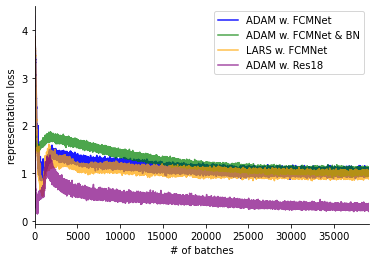

In [33]:
# Longer run comparison
fig, ax = plt.subplots()
plt.plot(BYOL_stats100["loss"],c='blue',alpha=0.9)
plt.plot(BYOL_stats_BN["loss"],c='green',alpha=0.7)
plt.plot(BYOL_stats_LARS["loss"],c='orange',alpha=0.7)
plt.plot(BYOL_stats_Res18Adam["loss"],c='purple',alpha=0.7)
plt.legend(["ADAM w. FCMNet","ADAM w. FCMNet & BN", "LARS w. FCMNet", "ADAM w. Res18"])
plt.xlabel("# of batches")
plt.ylabel("representation loss")
plt.xlim([0,len(BYOL_stats100["loss"])])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.show()
plt.savefig(figurePath+'BYOLComp' + figureFormat, bbox_inches='tight', dpi=dpi)

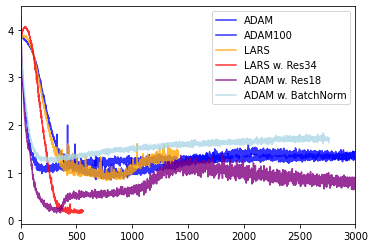

In [7]:
plt.figure()
plt.plot(BYOL_stats_test["loss"],c='blue',alpha=0.8)
plt.plot(BYOL_stats100["loss"],c='blue',alpha=0.8)
#plt.plot(BYOL_stats["classif_loss"]) # Always 0 since only one class
#plt.plot(BYOL_stats["repr_loss"]) # Same as loss
plt.plot(BYOL_stats_LARS["loss"],c='orange',alpha=0.8)
plt.plot(BYOL_stats_LARS_res34["loss"],c='red',alpha=0.8)
plt.plot(BYOL_stats_Res18Adam["loss"],c='purple',alpha=0.8)
plt.plot(BYOL_stats_BN["loss"],c='lightblue',alpha=0.8)
plt.legend(["ADAM","ADAM100","LARS","LARS w. Res34", "ADAM w. Res18", "ADAM w. BatchNorm"])
plt.xlim([0,3000])
plt.show()

In [7]:
# Log final run (1000 epochs):
BYOL_stats = load_stats("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_1000/")
checkpoint_data = load_checkpoint("/Users/vclay/nta/deepmind-research/ckpts/byol_OTC_1000/")

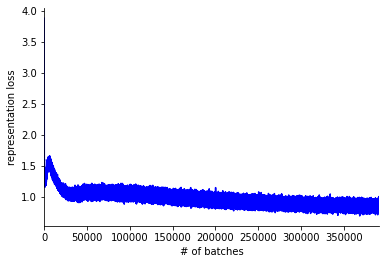

In [37]:
fig, ax = plt.subplots()
plt.plot(BYOL_stats["loss"],c='blue')
plt.xlabel("# of batches")
plt.ylabel("representation loss")
plt.xlim([0,len(BYOL_stats["loss"])])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
#plt.show()
plt.savefig(figurePath+'BYOLRun' + figureFormat, bbox_inches='tight', dpi=dpi)

In [ ]:
# should be ~391.386 steps long

In [22]:
# checkpoint_data['experiment_state'][0] contains parameters of online network
# checkpoint_data['experiment_state'][1] contains parameters of target network (almost same)
# checkpoint_data['experiment_state'][2] contains batch norm stats
for e in checkpoint_data['experiment_state'][0]:
    print(e)
    try:
        print(checkpoint_data['experiment_state'][0][e]['w'].shape)
    except:
        pass

classifier
(256, 1)
fcm_mlp/conv_1
(8, 8, 3, 16)
fcm_mlp/conv_2
(4, 4, 16, 32)
fcm_mlp/linear
(11552, 256)
fcm_mlp/linear_1
(256, 256)
predictor/batch_norm
predictor/linear
(256, 256)
predictor/linear_1
(256, 256)
projector/batch_norm
projector/linear
(256, 256)
projector/linear_1
(256, 256)


In [9]:
inImg = Input(batch_shape=(None,168, 168, 3),name="input_1")
conv = Conv2D(filters=16, kernel_size=[8, 8], strides=[4, 4],activation=tf.nn.elu,
    kernel_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/conv_1']['w']),
    bias_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/conv_1']['b']), name="conv_1")(inImg)
print(conv)
conv = Conv2D(filters=32, kernel_size=[4, 4], strides=[2, 2],activation=tf.nn.elu,
kernel_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/conv_2']['w']),
    bias_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/conv_2']['b']), name="conv_2")(conv)
print(conv)
flat = Reshape((19*19*32,))(conv)#Flatten()(conv)
print(flat)
dens = Dense(256,activation=swish,kernel_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/linear']['w']), 
    bias_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/linear']['b']),name="dens_1")(flat)
print(dens)
enc = Dense(256,activation=swish,kernel_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/linear_1']['w']),
    bias_initializer=tf.constant_initializer(checkpoint_data['experiment_state'][0]['fcm_mlp/linear_1']['b']), name="dens_2")(dens)
print(enc)

model = Model(inputs=inImg, outputs=enc)

model.compile()

KerasTensor(type_spec=TensorSpec(shape=(None, 41, 41, 16), dtype=tf.float32, name=None), name='conv_1/Elu:0', description="created by layer 'conv_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 19, 19, 32), dtype=tf.float32, name=None), name='conv_2/Elu:0', description="created by layer 'conv_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 11552), dtype=tf.float32, name=None), name='reshape_1/Reshape:0', description="created by layer 'reshape_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dens_1/Mul:0', description="created by layer 'dens_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 256), dtype=tf.float32, name=None), name='dens_2/Mul:0', description="created by layer 'dens_2'")


In [10]:
encBYOL = model.predict(obs)

In [11]:

balancedTestSetPath = '../../Results/TowerTraining/BalancedTestSet/'
np.save(balancedTestSetPath + 'encBYOL.npy',encBYOL)

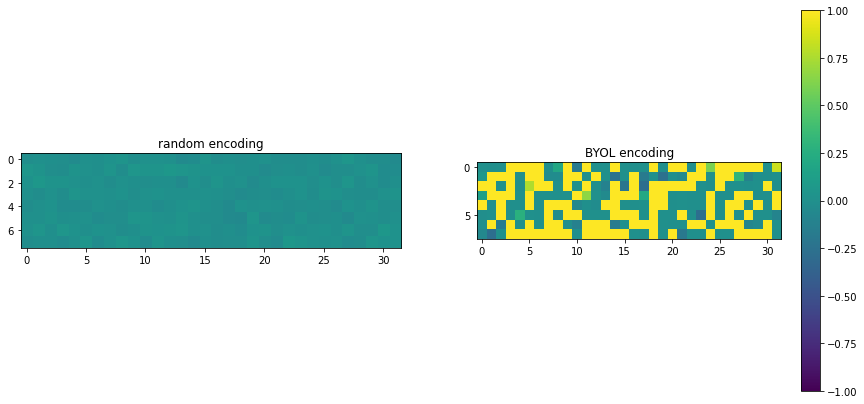

In [12]:
plot_range = 1
plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
plt.imshow(encRand[0].reshape((8,32)),vmin=-plot_range,vmax=plot_range)
plt.title("random encoding")
plt.subplot(1,2,2)
plt.imshow(encBYOL[0].reshape((8,32)),vmin=-plot_range,vmax=plot_range)
plt.title("BYOL encoding")
plt.colorbar()
plt.show()

In [13]:
tsneBYOL = TSNE(n_components=2,perplexity=70,random_state=0).fit_transform(encBYOL)

/Users/vclay/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/vclay/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


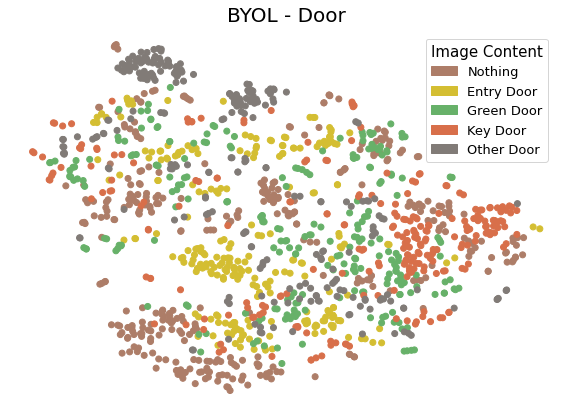

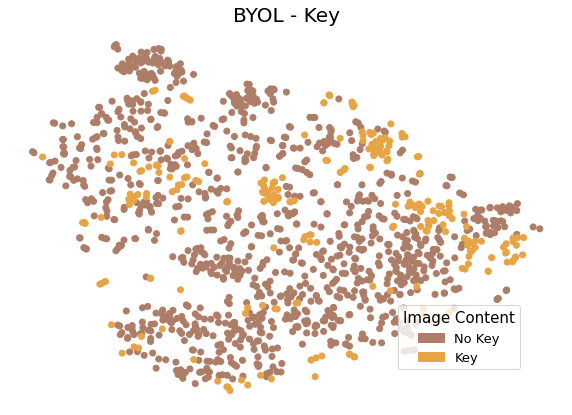

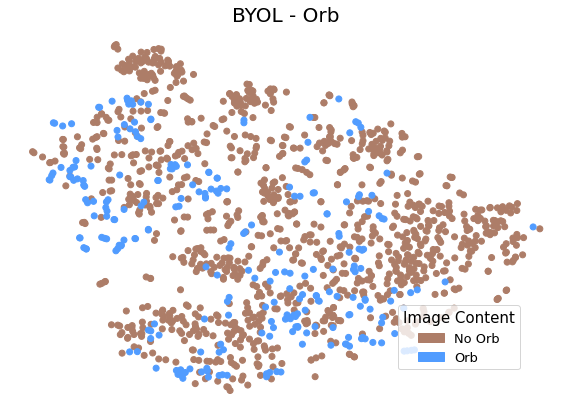

In [14]:
sem_label_names = [['Nothing','Entry Door','Green Door','Key Door','Other Door'],
                   ['No Key', 'Key'],
                   ['No Orb', 'Orb'],
                   ['No Puzzle', 'Puzzle']]
branches = ['Door','Key','Orb','Puzzle']

objectColors = [[np.array([173, 125, 104])/255,np.array([212, 190, 50])/255, np.array([103, 177, 105])/255,np.array([216, 111, 74])/255,np.array([129, 123, 119])/255],
             [np.array([173, 125, 104])/255,np.array([231, 164, 69])/255],
             [np.array([173, 125, 104])/255,np.array([81, 156, 255])/255],
             [np.array([173, 125, 104])/255,np.array([163, 118, 202])/255]]


for i in range(3):# Right now no plottig of puzzle since there are no puzzle frames in the excerpt
    
    contentLabels1 = y[:,i].astype(int)
    newOrder = np.append(np.where(contentLabels1==0),np.where(contentLabels1!=0))
    numClasses = len(sem_label_names[i])

    cmapnew = mpl.colors.ListedColormap(objectColors[i], name='Orbs')

    sem_lab = sem_label_names[i]

    plt.figure(figsize=(10,7))
    #plt.title('T-SNE on the Visual Embedding\nClassifier', fontsize=20)
    plt.title('BYOL - ' + branches[i], fontsize=20)
    im1 = plt.scatter(tsneBYOL[newOrder,0],tsneBYOL[newOrder,1],c=contentLabels1[newOrder],cmap=cmapnew)
    values = np.linspace(0,numClasses-1,numClasses)
    colors = [ im1.cmap(im1.norm(value)) for value in values]
    patches = [mpatches.Patch(color=colors[i], label=sem_lab[i] ) for i in range(len(values)) ]
    if i == 0:
        plt.legend(handles=patches, bbox_to_anchor=(0.75, 0.97), loc=2, borderaxespad=0. , title='Image Content',fontsize=13, title_fontsize=15)
    else:
        plt.legend(handles=patches, bbox_to_anchor=(0.7, 0.27), loc=2, borderaxespad=0. , title='Image Content',fontsize=13, title_fontsize=15)

    plt.axis('off')
    plt.show()# if not saveFigs else plt.savefig(figurePath+'tsne_semantic_'+c3Params['title'].replace(' ','') + '_' + branches[i] + figureFormat, bbox_inches='tight', dpi=dpi)
    plt.close()